In [475]:
%load_ext autoreload
%autoreload 2

from trend_detection import TrendDetector
import pandas as pd
import time
import random

from openai import AzureOpenAI
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

from trend_detection_embeddings import TrendDetectorEmbeddings

from preprocessing import preprocess_text
from profiler import profile_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_local = pd.read_json('data/local_events_messages_2.json')
df_local.head()

,event_name,category,text
0,Cherry blossom peak in Tokyo,NATURE,"""The city is vibrant! Sakura has peaked earlie..."
1,Traffic pile-up in Los Angeles,URBAN,"""Makes sense given LA traffic."" #LATraffic #40..."
2,Pop-up market in Barcelona,CULTURE,"""Love stumbling upon the unexpected! Barcelona..."
3,Street flooding in Mumbai,NATURE,"""Just when we thought monsoon season couldn't ..."
4,Food festival in Rome,CULTURE,"""Amazing variety of 50 regional pasta dishes h..."


In [45]:
df_local.iloc[41]["text"]

'"Wow, Tokyo\'s Sakura at its peak bloom  in 15 years! Can\'t wait to join the Hanami party 🌸 But major parks will suffer from crowding 😕 #Tokyo #Spring #Sakura"'

In [72]:
@profile_function()
def my_function():
    # Your function code here
    time.sleep(0.1)  # Example delay
    return sum(range(1000))


Performance Statistics for my_function():
Average time: 104.21 ms
Median time: 104.88 ms
Std dev: 1.34 ms
Min time: 101.09 ms
Max time: 105.20 ms
95th percentile: 105.18 ms


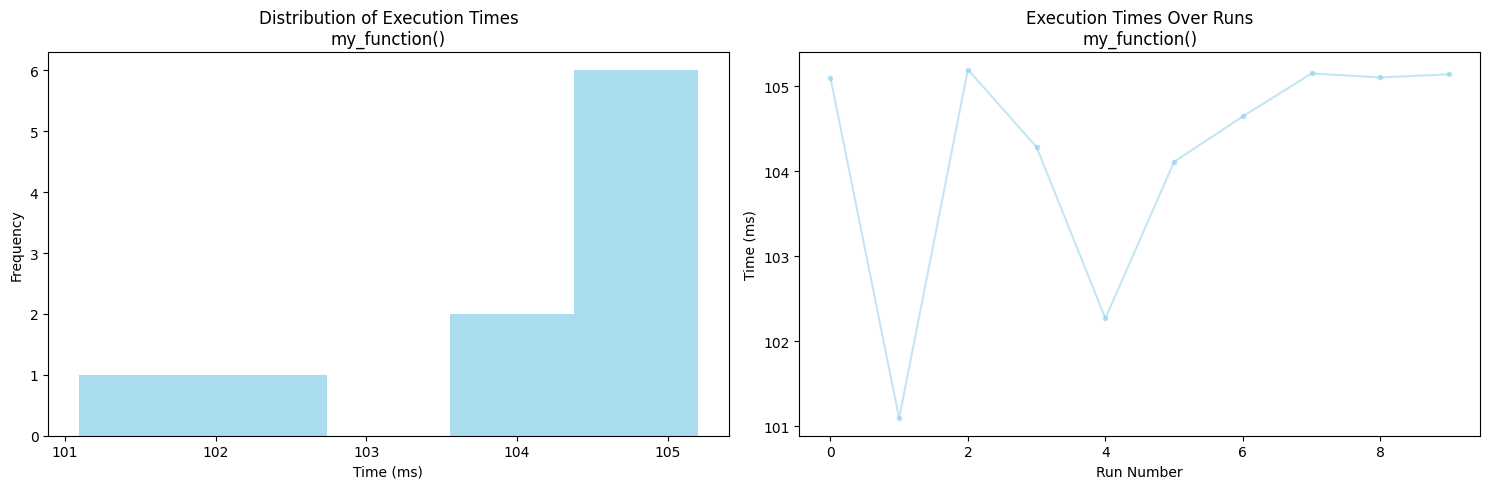

In [75]:
my_function.reset()

# Method 1: Run function normally multiple times, then analyze
for _ in range(10):
    my_function()

my_function.analyze()

In [79]:
@profile_function()
def run_trend_detect(td, message):
    td.process_message(message, "LA", time.time())

New Trend Created: ['tokyo', 'sakura']
New Trend Created: ['i-405', '12']
New Trend Created: ['times square', 'timessquare']
New Trend Created: ['santiago', 'chileprotests']
New Trend Created: ['chelsea', 'london']
New Trend Created: ['serengeti', 'perth']
New Trend Created: ['dublinrainbow', 'ireland']
New Trend Created: ['streetfood', 'bangkokfood']
New Trend Created: ['barcelona', 'gothic quarter']
New Trend Created: ['mumbai', 'mumbairains']
New Trend Created: ['stockholm', 'tonight']
New Trend Created: ['thousands', 'gangnam station']
New Trend Created: ['industry scouts', 'stem']
New Trend Created: ['foodieheaven', 'paris']
New Trend Created: ['dublin', 'traffic']
New Trend Created: ['sydneyblackout', 'sydney']
New Trend Created: ['younginnovators', 'londonscifair']
New Trend Created: ['melbourne', 'urban']
New Trend Created: ['ttcalert', 'torontotransit #commuterproblems']
New Trend Created: ['karlthefog', 'flight delays']
New Trend Created: ['berlinstrike', 'berlintransport']



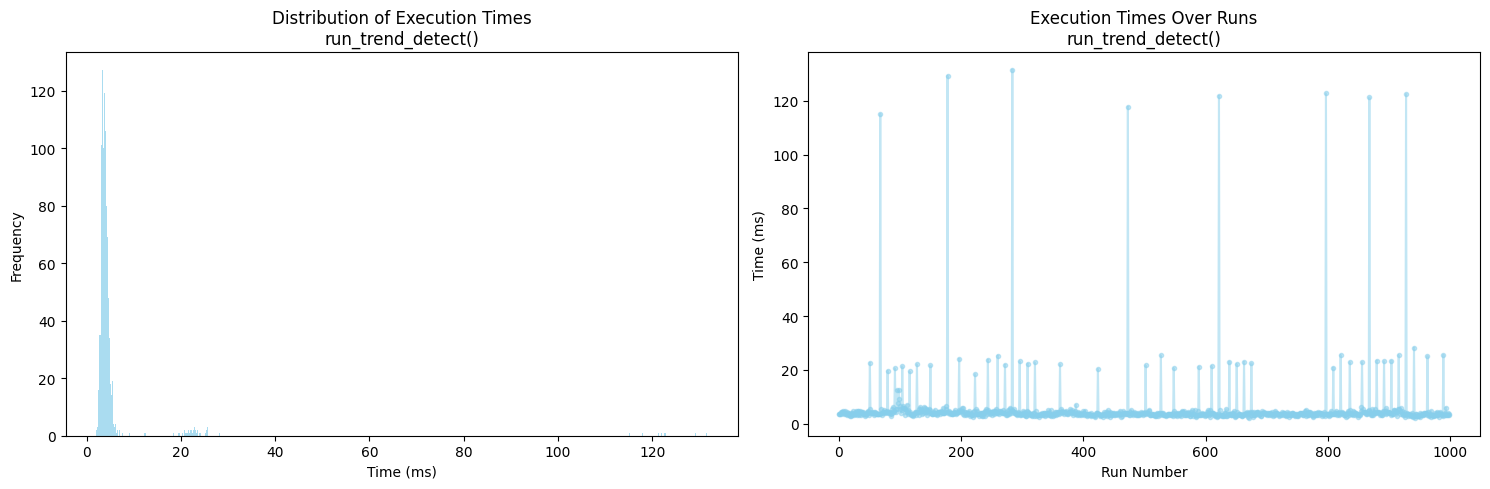

In [80]:
td = TrendDetector(trend_threshold=20)

run_trend_detect.reset()
for i, message in enumerate(list(df_local["text"])):
        # print(i)
        run_trend_detect(td, message)

run_trend_detect.analyze()

In [186]:
AZURE_OPENAI_ENDPOINT = "https://my-first-open-ai-service.openai.azure.com/openai/deployments/gpt-35-turbo/chat/completions?api-version=2024-08-01-preview"
AZURE_OPENAI_KEY = "uClNQwvESsEPxSFhKKonjSfIa8KDKUsyzLo7wl0rHzSpTI2qd40fJQQJ99AKACYeBjFXJ3w3AAABACOGgkTy"

openai_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_KEY,
    api_version="2024-02-15-preview"
)

def get_trend_name(keywords, m1, m2, temperature=0.7):
    PROMPT = f"""
        Generate a concise trend name with 5 words maximum based on:
        Core entities: {', '.join(keywords)}
        Sample messages: 
        - {m1}
        - {m2}
    """

    response = openai_client.chat.completions.create(
        model="gpt-35-turbo",
        
        temperature=temperature,
        response_format={"type": "text"},
        messages=[
                {"role": "system", "content": PROMPT},
                # {"role": "user", "content": user_prompt}
            ]
    )

    return response.choices[0].message.content.strip()

In [188]:
processed_messages = []

for m in df_local["text"]:
    processed_messages.append(preprocess_text(m))

df_local["text_processed"] = processed_messages

[nltk_data] Downloading package punkt to /Users/viktor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/viktor/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/viktor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/viktor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_local["text_processed"])
df_local['embeddings'] = embeddings

In [378]:
def cluster_messages(df, text_col, emebeddings_col, eps=0.7):
    embeddings = df[emebeddings_col]
    
    clustering = DBSCAN(eps, min_samples=3)
    labels = clustering.fit_predict(embeddings.tolist())
    df['cluster_processed'] = labels
    print(set(labels))
    
    grouped_processed_messages = df.groupby('cluster_processed').groups
    
    # Remove noise cluster (-1) if needed
    if -1 in grouped_processed_messages:
       del grouped_processed_messages[-1]

    top_n = 5
    clusters = []

    for _, cluster_idx in grouped_processed_messages.items():
        cluster_messages = df.iloc[cluster_idx]

        cluster_text = cluster_messages[text_col]
        cluster_embeddings = cluster_messages[emebeddings_col]
        
        vectorizer = TfidfVectorizer(max_features=100)
        tfidf = vectorizer.fit_transform(cluster_text)
        importance = np.asarray(tfidf.mean(axis=0)).ravel()
        top_idx = importance.argsort()[-top_n:][::-1]
        keywords = [vectorizer.get_feature_names_out()[i] for i in top_idx]

        trend_name = ""
        # trend_name = get_trend_name(keywords, cluster_messages[0], cluster_messages[1])
        clusters.append({
            "keywords": keywords,
            "cluster_messages": cluster_messages,
            "centroid": cluster_embeddings.apply(np.array).mean()
        })
    
        print(f'New Cluster ({len(cluster_messages)}): {trend_name}({keywords})')

    return clusters    

In [338]:
clusters1 = cluster_messages(df_local, 'text_processed', 'embeddings', eps=0.7)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(-1)}
New Cluster (100): (['tokyo', 'hanami', 'sakura', 'spring', 'peak'])
New Cluster (97): (['commute', 'latraffic', '405traffic', 'i405', '12car'])
New Cluster (100): (['street', 'barcelona', 'local', 'localcraft', 'market'])
New Cluster (100): (['monsoon', 'stay', 'safe', 'mumbairains', 'mumbaifloods'])
New Cluster (100): (['pasta', 'romefoodfest', 'italianfood', 'pastafestival', 'food'])
New Cluster (100): (['sydney', 'sydneyblackout', 'poweroutage', 'traffic', 'candlelit'])
New Cluster (100): (['stockholm', 'sky', 'darksky', 'weirdweather', 'tonight'])
New Cluster (100): (['nycmusic', 'timessquare', 'square', 'streetmusic', 'orchestra'])
New Cluster (100): (['education', 'santiago', 'chilepro

In [317]:
clusters2 = cluster_messages(df_local, 'text_processed', 'embeddings', eps=0.8)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)}
New Cluster (100): (['tokyo', 'hanami', 'sakura', 'spring', 'peak'])
New Cluster (100): (['commute', 'latraffic', '405traffic', 'i405', 'alternate'])
New Cluster (100): (['street', 'barcelona', 'local', 'localcraft', 'market'])
New Cluster (100): (['monsoon', 'stay', 'safe', 'mumbairains', 'mumbaifloods'])
New Cluster (300): (['popup', 'food', 'pasta', 'italianfood', 'romefoodfest'])
New Cluster (100): (['sydney', 'sydneyblackout', 'poweroutage', 'traffic', 'candlelit'])
New Cluster (100): (['stockholm', 'sky', 'darksky', 'weirdweather', 'tonight'])
New Cluster (100): (['nycmusic', 'timessquare', 'square', 'streetmusic', 'orchestra'])
New Cluster (100): (['education', 'santiago', 'chileprotests', 'reform', 'students'])
New Cluster (100): (['kpop',

In [349]:
def split_train_test(df, train_size=0.5):
    train_idx = []
    test_idx = []
    
    for event_name, message_idx in df.groupby('event_name').groups.items():
        train, test = train_test_split(message_idx, train_size=train_size)
        train_idx.extend(train)
        test_idx.extend(test)
    
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_df = train_df.reset_index()
    test_df = test_df.reset_index()

    return train_df, test_df

In [384]:
def check_matches_cluster_cosine(cluster_centroid, msg_embeddings):
    msg_embeddings = np.array(msg_embeddings)
    # Reshape to 2D arrays for sklearn
    centroid_2d = np.array(cluster_centroid).reshape(1, -1)
    msg_2d = np.array(msg_embeddings).reshape(1, -1)
    return cosine_similarity(centroid_2d, msg_2d)[0][0]

def check_matches_cluster_faiss(cluster_centroid, msg_embeddings):
    msg_embeddings = np.array(msg_embeddings)
    cluster_centroid = cluster_centroid / np.linalg.norm(cluster_centroid)
    msg_embeddings = msg_embeddings / np.linalg.norm(msg_embeddings)
    
    dimension = len(cluster_centroid)
    index = faiss.IndexFlatIP(dimension)  # Inner product = cosine similarity for normalized vectors
    
    # Add centroid to index
    index.add(np.array([cluster_centroid]).astype('float32'))
    
    # Search
    D, _ = index.search(np.array([msg_embeddings]).astype('float32'), k=1)
    return D[0][0]  # Return similarity score


In [385]:
def test_trend_detection_matching(df, train_size):
    train_df, test_df = split_train_test(df, train_size=train_size)

    train_df.reset_index()
    clusters = cluster_messages(train_df, 'text_processed', 'embeddings', eps=0.7)

    for cluster in clusters:
        cluster['new_messages'] = []
    
    for _, row in test_df.iterrows():
        row_text = row['text_processed']
        row_embeddings = row['embeddings']
        
        for cluster in clusters:
            cosine_sim = check_matches_cluster_cosine(cluster['centroid'], row_embeddings)
            
            if cosine_sim > 0.8:
                cluster['new_messages'].append(row_text)

    for cluster in clusters:
        print(cluster['keywords'], len(cluster['new_messages']))

In [386]:
test_trend_detection_matching(df_local, 0.5)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(-1)}
New Cluster (50): (['tokyo', 'hanami', 'sakura', 'peak', 'spring'])
New Cluster (50): (['kpop', 'seoulflashmob', 'dance', 'gangnamstation', 'traffic'])
New Cluster (50): (['karlthefog', 'fogcity', 'delays', 'flight', 'fog'])
New Cluster (50): (['pasta', 'italianfood', 'romefoodfest', 'pastafestival', 'food'])
New Cluster (50): (['food', 'thailand', 'market', 'streetfood', 'bangkokfood'])
New Cluster (50): (['festival', 'brazil', 'riocarnival', 'parades', 'music'])
New Cluster (50): (['education', 'santiago', 'students', 'chileprotests', 'reform'])
New Cluster (50): (['street', 'barcelona', 'local', 'market', 'quarter'])
New Cluster (50): (['sydney', 'sydneyblackout', 'poweroutage', 'traffic',

In [387]:
test_trend_detection_matching(df_local, 0.1)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(-1)}
New Cluster (10): (['tokyo', 'hanami', 'sakura', 'peak', 'spring'])
New Cluster (10): (['kpop', 'dance', 'gangnamstation', 'seoulflashmob', 'traffic'])
New Cluster (10): (['karlthefog', 'fogcity', 'delays', 'views', 'flight'])
New Cluster (9): (['pasta', 'italianfood', 'romefoodfest', 'food', 'pastafestival'])
New Cluster (10): (['food', 'market', 'streetfood', 'thailand', 'bangkokfood'])
New Cluster (10): (['brazil', 'festival', 'riocarnival', 'music', 'beach'])
New Cluster (10): (['education', 'santiago', 'chileprotests', 'reform', 'students'])
New Cluster (10): (['street', 'barcelona', 'gothic', 'food', 'quarter'])
New Cluster (10): (['sydney', 'sydneyblackout', 'traffic', 'cbd', 'signals'

New Trend created: tokyo, hanami, sakura, spring, peak
New Trend created: education, santiago, chileprotests, reform, protest
New Trend created: stockholm, weirdweather, darksky, sky, tonight
New Trend created: chelsea, flash, celebration, streets, traffic
New Trend created: popup, foodieheaven, parisfood, famous, restaurant
New Trend created: orchestra, nycmusic, flash, streetmusic, timessquare
New Trend created: wildlife, migration, cant, celebration, london
New Trend created: food, thailand, market, bangkokfood, streetfood
New Trend created: brazil, festival, riocarnival, parades, music
New Trend created: weather, food, sydney, candlelit, sydneyblackout
New Trend created: kpop, seoulflashmob, gangnamstation, traffic, thousands
New Trend created: today, see, londonscifair, projects, delays
New Trend created: monsoon, stay, mumbairains, mumbaifloods, safe
New Trend created: art, urban, melbourneart, streetart, mural
New Trend created: celebration, traffic, delays, karlthefog, fogcity


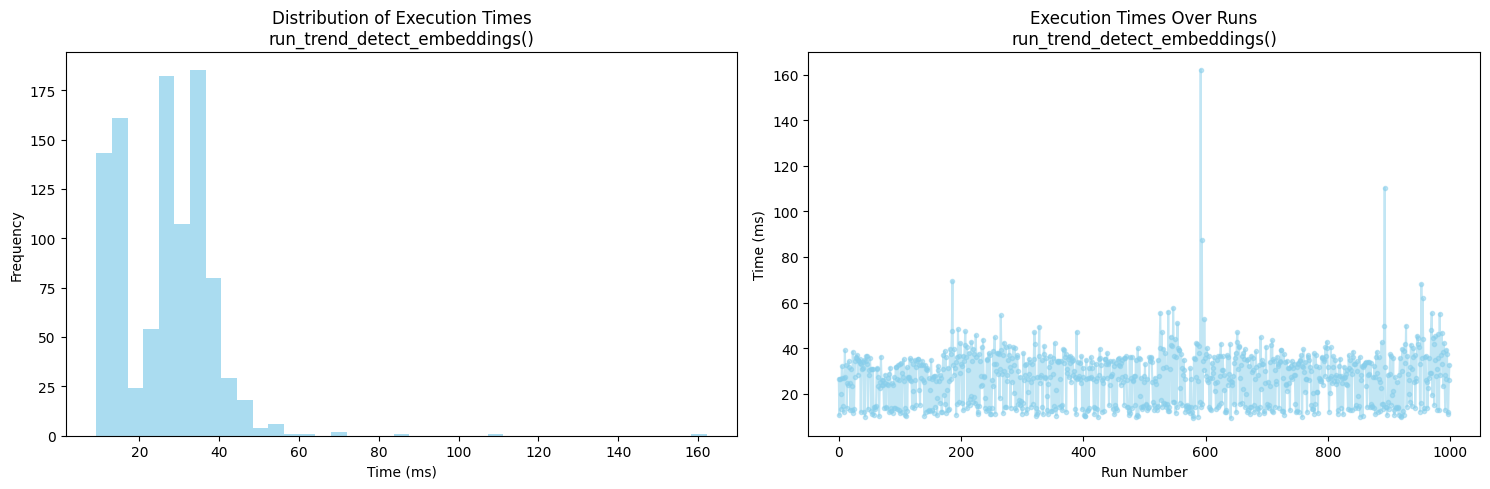

In [436]:
@profile_function()
def run_trend_detect_embeddings(td, message):
    td.process_message(message, "LA", time.time())

td = TrendDetectorEmbeddings()

# df = df_local[df_local['event_name'] == 'Cherry blossom peak in Tokyo']
# df = df_local[df_local['event_name'] == 'Street flooding in Mumbai']
# df = df_local[df_local['event_name'].isin(['Cherry blossom peak in Tokyo', 'Street flooding in Mumbai'])]
# df = df[:80]

df = df_local

run_trend_detect_embeddings.reset()
messages = list(df["text_processed"])
random.shuffle(messages)

for i, message in enumerate(messages):
        # print(i)
        run_trend_detect_embeddings(td, message)

run_trend_detect_embeddings.analyze()

['Cherry blossom peak in Tokyo', 'Rainbow phenomenon in Dublin']

/var/folders/dd/hn5sg82j5fl1y3tj3xbr8g4m0000gn/T/ipykernel_92271/156766619.py:19: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(messages, random=myfunction)


New Trend created: monsoon, mumbai, stay, safe, mumbairains
New Trend created: amazing, london, making, younginnovators, young
New Trend created: street, barcelona, food, quarter, music
New Trend created: weather, storm, ireland, triple, traffic
New Trend created: flash, streetmusic, orchestra, nycmusic, timessquare
New Trend created: stem, londonscifair, projects, industry, younginnovators
New Trend created: celebration, chelsea, champions, london, streets
New Trend created: urban, art, hanami, tokyo, peak
New Trend created: urban, art, streetart, melbourneart, mural
New Trend created: tokyo, hanami, sakura, years, peak

Performance Statistics for run_trend_detect_embeddings():
Average time: 22.82 ms
Median time: 24.20 ms
Std dev: 9.49 ms
Min time: 8.59 ms
Max time: 48.07 ms
95th percentile: 35.65 ms


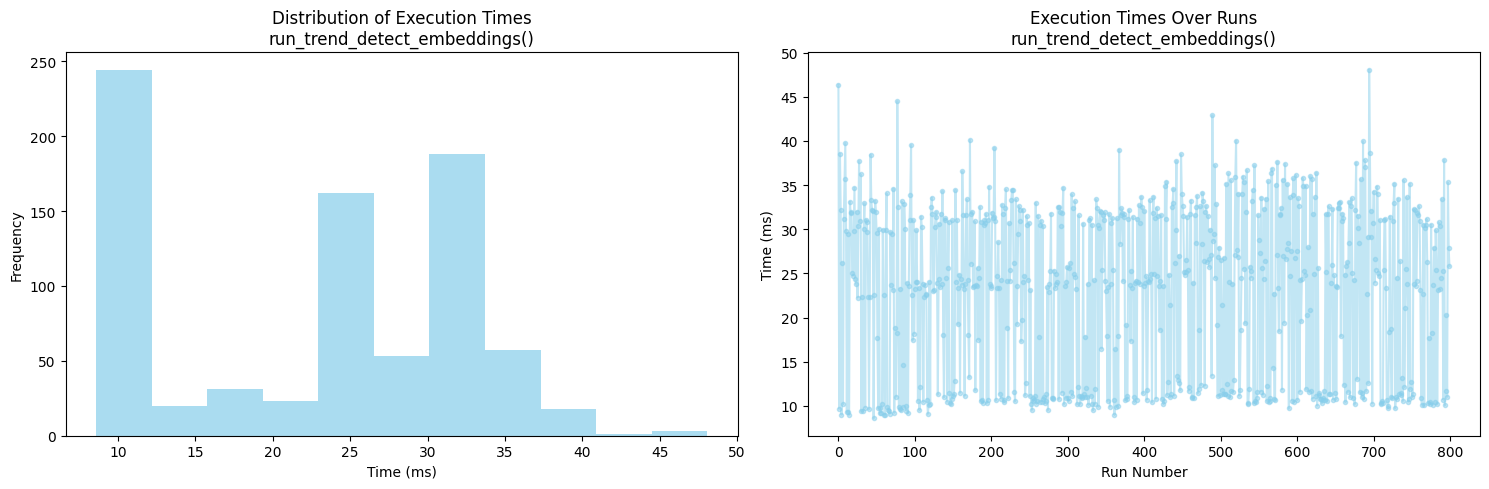

In [453]:
@profile_function()
def run_trend_detect_embeddings(td, message):
    td.process_message(message, "LA", time.time())

td = TrendDetectorEmbeddings()

# df = df_local[df_local['event_name'] == 'Cherry blossom peak in Tokyo']
# df = df_local[df_local['event_name'] == 'Street flooding in Mumbai']

df = df_local[df_local['event_name'].isin(list(set(df_local['event_name']))[:8])]

# df = df_local

def myfunction():
  return 0.1

run_trend_detect_embeddings.reset()
messages = list(df["text_processed"])
random.shuffle(messages, random=myfunction)

for i, message in enumerate(messages):
        # print(i)
        run_trend_detect_embeddings(td, message)

run_trend_detect_embeddings.analyze()

In [459]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/var/folders/dd/hn5sg82j5fl1y3tj3xbr8g4m0000gn/T/ipykernel_92271/4215631618.py:19: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(messages, random=myfunction)


New Trend created: nycmusic, orchestra, streetmusic, traffic, timessquare
New Trend created: stockholm, sky, darksky, weirdweather, atmospheric
New Trend created: young, stem, innovators, londonscifair, younginnovators
New Trend created: education, santiago, chileprotests, reform, students
New Trend created: kpop, dance, seoulflashmob, gangnamstation, gangnam
New Trend created: celebration, chelsea, fans, london, champions
New Trend created: food, thailand, streetfood, bangkokfood, market
New Trend created: migration, wildlife, safari, perth, serengeti
New Trend created: urban, art, melbourneart, streetart, mural
New Trend created: weather, rainbow, triple, storm, ireland
New Trend created: transit, berlinstrike, berlintransport, alternative, strike
New Trend created: festival, brazil, riocarnival, beach, parades
New Trend created: sydney, sydneyblackout, poweroutage, dinner, cbd
New Trend created: italianfood, romefoodfest, pasta, pastafestival, regional
New Trend created: hanami, tok

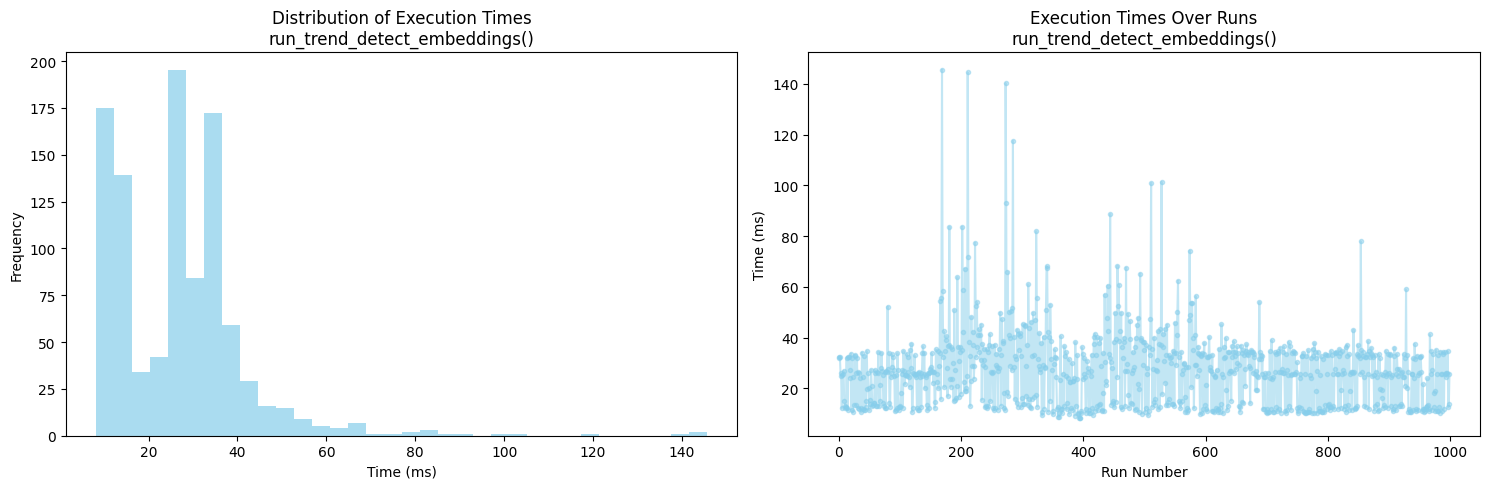

In [481]:
@profile_function()
def run_trend_detect_embeddings(td, message):
    td.process_message(message, "LA", time.time())

td = TrendDetectorEmbeddings(model=model)

# df = df_local[df_local['event_name'] == 'Cherry blossom peak in Tokyo']
# df = df_local[df_local['event_name'] == 'Street flooding in Mumbai']

# df = df_local[df_local['event_name'].isin(list(set(df_local['event_name']))[:8])]

df = df_local

def myfunction():
  return 0.1

run_trend_detect_embeddings.reset()
messages = list(df["text_processed"])
random.shuffle(messages, random=myfunction)

for i, message in enumerate(messages):
        # print(i)
        run_trend_detect_embeddings(td, message)

run_trend_detect_embeddings.analyze()

In [482]:
len(td.messages)

545

In [484]:
mcount_original = []
mcount_matched = []

for trend in td.trends.values():
    mcount_original.append(trend.original_messages_cnt)
    mcount_matched.append(trend.matched_messages_cnt)

print(sum(mcount_original), sum(mcount_matched))

327 1555


In [464]:
TOPICS = {
   'sport': model.encode(["tournament", "championship", "match", "game", "player", "team", "score", "athlete", "win", "league", "coach", "stadium", "sports", "competition", "victory"]).mean(axis=0),
   
   'entertainment': model.encode(["movie", "film", "actor", "show", "concert", "music", "celebrity", "performance", "TV", "series", "award", "premiere", "star", "festival", "entertainment"]).mean(axis=0),
   
   'technology': model.encode(["software", "hardware", "app", "device", "digital", "startup", "innovation", "AI", "mobile", "computer", "tech", "update", "release", "platform", "developer"]).mean(axis=0),
   
   'finance': model.encode(["stock", "market", "investment", "bank", "trading", "economy", "financial", "currency", "profit", "shares", "investors", "growth", "revenue", "earnings", "assets"]).mean(axis=0),
   
   'politics': model.encode(["government", "election", "policy", "vote", "leader", "president", "minister", "campaign", "party", "law", "congress", "senate", "parliament", "legislation", "poll"]).mean(axis=0)
}

In [470]:
def find_best_topic(embedding, topics):
   best_similarity = -1
   best_topic = None
   
   for topic_name, topic_embedding in topics.items():
       similarity = cosine_similarity(
           np.array(embedding).reshape(1, -1),
           topic_embedding.reshape(1, -1)
       )[0][0]
       
       if similarity > best_similarity:
           best_similarity = similarity
           best_topic = topic_name
           
   return best_topic

# Apply to dataframe
df_local['topic'] = df_local['embeddings'].apply(lambda x: find_best_topic(x, TOPICS))

In [472]:
df_local.groupby('topic').count()

,event_name,category,text,embeddings,cluster,text_processed,cluster_processed
topic,,,,,,,
entertainment,1068,1068,1068,1068,1068,1068,1068
finance,163,163,163,163,163,163,163
politics,509,509,509,509,509,509,509
sport,152,152,152,152,152,152,152
technology,208,208,208,208,208,208,208
